In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Thảo/GERD/GERD_data_1'

/content/gdrive/MyDrive/Thảo/GERD/GERD_data_1


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import numpy as np

In [4]:
base_path = '/content/gdrive/MyDrive/Thảo/GERD/GERD_data_1'

In [5]:
labels = ['GERD_A', 'GERD_B']

In [6]:
BATCH_SIZE = 32
VERBOSE = 1
IMAGE_SIZE = 224

In [7]:
# Dataset from the training folder.
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'train'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

100%|██████████| 511/511 [02:38<00:00,  3.22it/s]

Training dataset Loading complete.


In [8]:
# Dataset from the testing folder..
x_test = []
y_test = []
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'test'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_test.append(img)
        y_test.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)
x_test, y_test = sklearn.utils.shuffle(x_test, y_test, random_state=0)
print('Testing dataset Loading complete.')

100%|██████████| 17/17 [00:04<00:00,  3.44it/s]

Testing dataset Loading complete.


In [9]:
x_valid = []
y_valid = []
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'valid'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_valid.append(img)
        y_valid.append(i)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_valid, y_valid = sklearn.utils.shuffle(x_valid, y_valid, random_state=0)

print('Valid dataset Loading complete.')

100%|██████████| 25/25 [00:06<00:00,  3.77it/s]

Valid dataset Loading complete.


In [10]:
# One-hot encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


y_valid_new = []
for i in y_valid:
    y_valid_new.append(labels.index(i))
y_valid = y_valid_new
y_valid = tf.keras.utils.to_categorical(y_valid)

In [11]:

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, vertical_flip=True
)

In [12]:
base = ResNet50(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
# Adding Top Layers.
model1 = base.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(0.5)(model1)
model1 = tf.keras.layers.Dense(1024, activation='sigmoid')(model1)
model1 = tf.keras.layers.Dense(2, activation = 'sigmoid')(model1)
model1 = tf.keras.models.Model(inputs = base.input, outputs = model1)

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
# Compiling Model
# from keras.optimizers import SGD
# opt = SGD(learning_rate=0.01)
model1.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics=['accuracy'])

In [14]:
# Callbacks.
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet50.h5", save_weights_only=True, monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [15]:
# Fitting the model
history1 = model1.fit(x = datagen.flow(x_train, y_train, batch_size = BATCH_SIZE), validation_data=(x_test, y_test), epochs = 20, verbose =VERBOSE, callbacks=[tensorboard,checkpoint,reduce_lr], steps_per_epoch = len(x_train) // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
32/32 [==============================] - 37s 475ms/step - loss: 0.6729 - accuracy: 0.6982 - val_loss: 0.8141 - val_accuracy: 0.4048

Epoch 00001: val_accuracy improved from -inf to 0.40476, saving model to resnet50.h5
Epoch 2/20
32/32 [==============================] - 13s 413ms/step - loss: 0.5855 - accuracy: 0.7351 - val_loss: 1.1298 - val_accuracy: 0.5952

Epoch 00002: val_accuracy improved from 0.40476 to 0.59524, saving model to resnet50.h5
Epoch 3/20
32/32 [==============================] - 13s 414ms/step - loss: 0.5622 - accuracy: 0.7291 - val_loss: 1.0336 - val_accuracy: 0.4048

Epoch 00003: val_accuracy did not improve from 0.59524
Epoch 4/20
32/32 [==============================] - 13s 412ms/step - loss: 0.5371 - accuracy: 0.7510 - val_loss: 1.2079 - val_accuracy: 0.4524

Epoch 00004: val_accuracy did not improve from 0.59524

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/20
32/32 [==============================] - 13s 404m

In [16]:
model1.load_weights('resnet50.h5')

In [17]:
result1=model1.evaluate(x_valid, y_valid)
print("Testing Loss :", result1[0])
print("Testing Accuracy :", result1[1]*100, "%")

2/2 [==============================] - 0s 204ms/step - loss: 0.4387 - accuracy: 0.8200
Testing Loss : 0.43873322010040283
Testing Accuracy : 81.99999928474426 %


In [18]:
predictions1 = model1.predict(x_valid)
predictions1 = np.argmax(predictions1, axis = 1)
y_valid_edit = np.argmax(y_valid , axis = 1)

In [19]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_valid_edit, predictions1)
print(cf_report)

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.79      0.88      0.83        25

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82      0.82      0.82        50



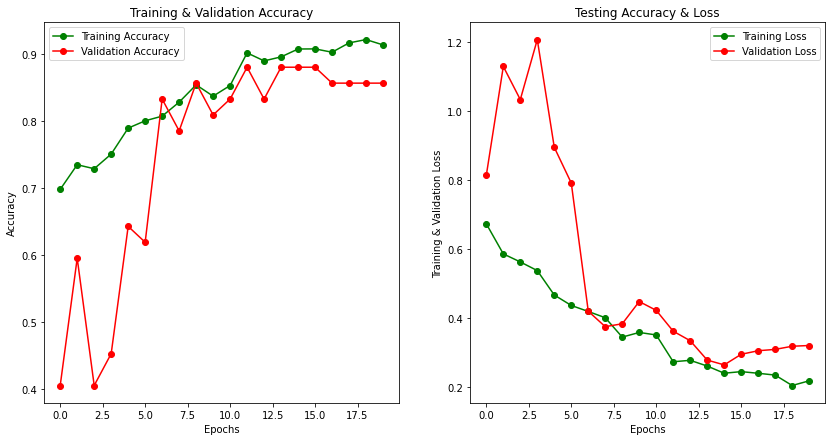

In [20]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()